# Aperture photometry with Pymc3
In this short tutorial we extract aperture photometry for a particular set of 4 sources that are close to each other, and that have been observed in 10 different Chandra Observations. [Pymc3](https://docs.pymc.io/en/v3/) is a pyhton package that allows for efficient MCMC sampling using the NUTS algorithm, that is a particular case of Hamiltonian Monte Carlo techniques. Let's first get some basic imports in:

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from astropy.io import fits
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.2


Let us explore the input files. These prep3 files are simply tables that contain the $\theta_i$ and $\phi$ quantities that we have defined in the lecture, and which are the expected total number of counts in the source apertures and background aperture respectively. They are matrices because they need to account for the fraction of each PSF ecclosed in each aperture.  Let us inspect one of them:

In [3]:
hdul0 = fits.open('acisf04703_000N021_b0103_b_detect_prep3.fits')
hdul0.info()

Filename: acisf04703_000N021_b0103_b_detect_prep3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  PSF           1 BinTableHDU    171   5R x 1C   [5D]   
  2  source_properties    1 BinTableHDU    193   5R x 13C   [4A, 1J, 1D, 1D, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1L]   
  3  PSFUNEX       1 BinTableHDU    171   5R x 1C   [5D]   
  4  PSFLIVE       1 BinTableHDU    171   5R x 1C   [5D]   
  5  PSFFLUX       1 BinTableHDU    171   5R x 1C   [5D]   


Each of the 5 extensions of the FITS file contains different information. In particular, Extension 2 contains the measured counts in each of the apertures, and extension 5 corresponds to the factors you need to multiply the counts by in order to recover fluxes. This is in general, as we have seen in the lecture, a combination of exposure map, PSF fraction, etc.

In [28]:
hdul0[2].data

FITS_rec([('0108',  16, 5.18960139e-06, 3.02411988e-06, 4.0652190e-15,  8086.9272, 2.37298954e-14, 1.67239067e-14, 1.25416439e-03, 7.00231062e-04, 7.37422533e+00, 4.11721275e+00,  0),
          ('0128',   3, 1.27367359e-07, 1.32712338e-06, 1.2315064e-15,  1941.0303, 0.00000000e+00, 2.44112017e-15, 4.28762662e-05, 3.04083969e-04, 2.52103512e-01, 1.78795038e+00,  0),
          ('0167',   5, 2.91202589e-06, 2.09153024e-06, 1.9806775e-15,  2495.2769, 4.84597241e-16, 5.67915263e-15, 6.85987512e-04, 4.82772470e-04, 4.03346364e+00, 2.83860154e+00,  0),
          ('0210',   5, 1.22148583e-06, 1.70520785e-06, 2.8444982e-15,  2904.0845, 0.00000000e+00, 6.59652140e-15, 2.92444340e-04, 3.89134833e-04, 1.71951179e+00, 2.28803174e+00,  0),
          ('-1', 189, 9.04093205e-10, 6.58385036e-11, 5.2858858e-15, 81838.97  , 6.26505169e-18, 4.56012322e-19, 2.01471954e-07, 1.46723054e-08, 1.18461311e-03, 8.62700990e-05,  0)],
         dtype=(numpy.record, [('component_ids', 'S4'), ('counts', '>i4'), ('phot

In [4]:
hdul0[5].data['psf_matrix']

array([[2.43453402e+14, 9.23814804e+12, 4.69595800e+13, 3.00546608e+11,
        1.64466478e+18],
       [2.92426525e+11, 7.91999982e+14, 2.71637031e+11, 1.08230002e+11,
        1.88495023e+18],
       [7.04549317e+11, 6.81223938e+10, 3.98565192e+14, 2.45619849e+12,
        7.65950061e+17],
       [1.50342373e+11, 2.37174501e+10, 2.43047091e+12, 3.45581532e+14,
        9.73001147e+17],
       [1.10710551e+12, 2.26332145e+12, 1.67497028e+12, 1.64740875e+12,
        3.01678846e+19]])

## Building the probabilistinc model 
We now construct the model that we will use to perform inference on the source fluxes. This model is basically summarized in the expressions:

$$\theta_i = E_i \times \bigg[\sum_{j=1}^{n}f_{ij}s_j + \Omega_i b\bigg]$$

$$\phi = E_b \times \bigg[\sum_{j=1}^{n}g_is_i + \Omega b\bigg]$$

where $f_{ij}$ and $g_{i}$ are respectively the PSF fractions enclosed in each of the apertures, $E_i$ and $E_b$ are the average exposure values in those apertures, $s_i$ and b are the net counts in the apertures, and $\Omega_i$ and $\Omega$ are the areas of the apertures. Let's code this up. First, we construct structures $C$ and theta_comp that will contain the arrays of expected number of counts, and the observed counts.

In [32]:
theta = [] # This will contain the arrays of thetas and phi
C = []
for file in glob.glob('*b0103*prep3*'):  # Select of files corresponding to the group of detections
    print(file)
    hdul = fits.open(file)
    theta_comp = []
    for value in hdul[5].data['psf_matrix'].T:  
        print(value)
        theta_comp.append([value[0],value[1],value[2],value[3],value[4]])
    C_comp = hdul[2].data['counts']
    theta_comp = np.array(theta_comp)
    #print(theta_comp)
    #print(np.shape(theta_comp))
    theta.append(theta_comp)
    C.append(C_comp)

acisf04703_000N021_b0103_b_detect_prep3.fits
[2.43453402e+14 2.92426525e+11 7.04549317e+11 1.50342373e+11
 1.10710551e+12]
[9.23814804e+12 7.91999982e+14 6.81223938e+10 2.37174501e+10
 2.26332145e+12]
[4.69595800e+13 2.71637031e+11 3.98565192e+14 2.43047091e+12
 1.67497028e+12]
[3.00546608e+11 1.08230002e+11 2.45619849e+12 3.45581532e+14
 1.64740875e+12]
[1.64466478e+18 1.88495023e+18 7.65950061e+17 9.73001147e+17
 3.01678846e+19]
acisf04702_000N021_b0103_b_detect_prep3.fits
[6.95189546e+14 2.12415222e+11 2.61175972e+11 2.58672931e+11
 1.40510998e+12]
[2.93358422e+13 4.80542320e+14 7.76719111e+10 6.27287801e+10
 2.66198152e+12]
[1.43378476e+14 2.41817918e+11 2.21280640e+14 4.00242666e+13
 1.95450312e+12]
[7.71163094e+11 9.39676908e+10 1.59602517e+11 3.60631204e+14
 1.90540643e+12]
[4.70033047e+18 1.14893845e+18 3.45619509e+17 1.18152180e+18
 3.35750865e+19]
acisf04701_001N021_b0103_b_detect_prep3.fits
[7.08938702e+14 1.87225797e+11 2.17051876e+11 2.57336581e+11
 1.46805620e+12]
[3.1596

In [31]:
hdul[5].data['psf_matrix'].T

array([[3.98634699e+14, 8.66658237e+10, 2.61381213e+11, 1.34478446e+11,
        1.22856995e+12],
       [1.22400407e+13, 3.49734317e+14, 6.17041139e+10, 3.55056743e+10,
        1.76813769e+12],
       [6.57475180e+13, 9.36813974e+10, 1.90671068e+14, 1.62706160e+12,
        1.33133825e+12],
       [4.73129100e+11, 1.55490418e+10, 7.58601859e+11, 3.16615367e+14,
        1.34853905e+12],
       [2.69326095e+18, 8.29738776e+17, 3.52750823e+17, 8.88725677e+17,
        2.39557558e+19]])

In [33]:
theta

[array([[2.43453402e+14, 2.92426525e+11, 7.04549317e+11, 1.50342373e+11,
         1.10710551e+12],
        [9.23814804e+12, 7.91999982e+14, 6.81223938e+10, 2.37174501e+10,
         2.26332145e+12],
        [4.69595800e+13, 2.71637031e+11, 3.98565192e+14, 2.43047091e+12,
         1.67497028e+12],
        [3.00546608e+11, 1.08230002e+11, 2.45619849e+12, 3.45581532e+14,
         1.64740875e+12],
        [1.64466478e+18, 1.88495023e+18, 7.65950061e+17, 9.73001147e+17,
         3.01678846e+19]]),
 array([[6.95189546e+14, 2.12415222e+11, 2.61175972e+11, 2.58672931e+11,
         1.40510998e+12],
        [2.93358422e+13, 4.80542320e+14, 7.76719111e+10, 6.27287801e+10,
         2.66198152e+12],
        [1.43378476e+14, 2.41817918e+11, 2.21280640e+14, 4.00242666e+13,
         1.95450312e+12],
        [7.71163094e+11, 9.39676908e+10, 1.59602517e+11, 3.60631204e+14,
         1.90540643e+12],
        [4.70033047e+18, 1.14893845e+18, 3.45619509e+17, 1.18152180e+18,
         3.35750865e+19]]),
 array

In [8]:
C

[array([ 16,   3,   5,   5, 189], dtype=int32),
 array([ 16,  10,   2,  11, 163], dtype=int32),
 array([ 16,   8,   4,   8, 196], dtype=int32),
 array([ 27,   6,   5,   4, 199], dtype=int32),
 array([ 36,   6,   8,   8, 205], dtype=int32),
 array([ 196,   87,   42,   79, 1295], dtype=int32),
 array([ 25,  11,   8,   5, 154], dtype=int32),
 array([ 20,  10,   4,  10, 165], dtype=int32),
 array([ 24,   8,   1,   5, 188], dtype=int32),
 array([ 24,  12,   7,   6, 193], dtype=int32)]

In [9]:
len(theta)

10

We now implement the model. We first define uniform priors for $s_i$ and $b$, which are the parameters we are trying to infer, and set the boundaries of those uniform priors. Then we define the expected value of the outcome (mu), which is given by the expressions above. We then define the Poisson model for the arival of photons in each of the apertures. The way in which we do this is by directly setting ths statistic to the cash statistic, that we define explicitely below. Finally, we write the likelihood as this cash statistic, and specify the observed values

In [10]:
# Now we implement the PyMC3 model
basic_model = pm.Model()
with basic_model as model:
    # Priors for unknown model parameters
    s = pm.Uniform('s', lower=0.0, upper=1E-12, shape=(4,))
    b = pm.Uniform('b', lower=0.0, upper=1E-15)
    
    # Expected value of outcome
    mu = []
    for i in range(len(theta)):
        mu.append(s[0]*theta[i][0] + s[1]*theta[i][1] + s[2]*theta[i][2] + 
                  s[3]*theta[i][3] + b*theta[i][4]) # This also has to match the number of sources
    
    # Cash statistic
    def cash(observed_counts):
        logpm = np.array(mu - observed_counts*np.log(mu))
        return -2.0*np.sum(logpm)
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.DensityDist('C_obs', cash, observed=C)

In [11]:
# Now we do MCMC sampling
with basic_model:
    trace = pm.sample(1000,tune=1000,target_accept=0.9, cores=2, return_inferencedata=True)
    #trace = pm.sample(200,tune=1000,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


/var/folders/14/ndt0htr925q12gxv25s271x00000gn/T/ipykernel_84872/2006739585.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  trarr = pm.traceplot(trace)


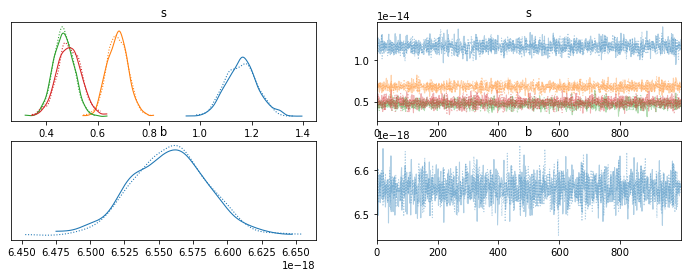

In [12]:
# Plot traces
trarr = pm.traceplot(trace)
fig = plt.gcf()

In [13]:
# Print MCMC summary
summary = pm.stats.summary(trace,round_to='none')
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
s[0],1.160205e-14,6.184796e-16,1.043950e-14,1.273444e-14,1.568725e-17,1.109464e-17,1547.077794,1284.872840,1.000598
s[1],6.774671e-15,4.033258e-16,6.046089e-15,7.527901e-15,9.241051e-18,6.535410e-18,1905.559727,1547.835606,0.999873
s[2],4.678495e-15,3.970488e-16,3.882801e-15,5.373522e-15,8.822210e-18,6.278809e-18,2035.297786,1455.379871,1.001797
s[3],4.888831e-15,4.715993e-16,3.983058e-15,5.799033e-15,1.001826e-17,7.457727e-18,2220.620977,1263.153802,0.999548
b,6.557765e-18,2.739864e-20,6.509895e-18,6.611225e-18,6.126522e-22,4.332737e-22,2116.937562,1414.091405,1.003564


In [15]:
#trace['s']

In [16]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [17]:
import arviz as az
az.summary(trace, kind="stats",fmt='wide',round_to='none')

,mean,sd,hdi_3%,hdi_97%
s[0],1.160205e-14,6.184796e-16,1.043950e-14,1.273444e-14
s[1],6.774671e-15,4.033258e-16,6.046089e-15,7.527901e-15
s[2],4.678495e-15,3.970488e-16,3.882801e-15,5.373522e-15
s[3],4.888831e-15,4.715993e-16,3.983058e-15,5.799033e-15
b,6.557765e-18,2.739864e-20,6.509895e-18,6.611225e-18


## Single obsid case
What happens if, rather than getting a model from all the observations of each source simultaneously, I am interested in extracting fluxes individually from each observation? This is useful, since a comparison between the likelihood of a model that assumes a single flux for all observations vs. one that assumes different fluxes for each will inform us about variability. In this case we take only one observation.

In [18]:
theta = []
C = []
for file in glob.glob('acisf04703_000N021_b0103*'):
    print(file)
    hdul = fits.open(file)
    theta_comp = []
    for value in hdul[5].data['psf_matrix'].T:
        #print(value)
        theta_comp.append([value[0],value[1],value[2],value[3],value[4]])
    C_comp = hdul[2].data['counts']
    theta_comp = np.array(theta_comp)
    print(theta_comp)
    print(np.shape(theta_comp))
    theta.append(theta_comp)
    C.append(C_comp)

acisf04703_000N021_b0103_b_detect_prep3.fits
[[2.43453402e+14 2.92426525e+11 7.04549317e+11 1.50342373e+11
  1.10710551e+12]
 [9.23814804e+12 7.91999982e+14 6.81223938e+10 2.37174501e+10
  2.26332145e+12]
 [4.69595800e+13 2.71637031e+11 3.98565192e+14 2.43047091e+12
  1.67497028e+12]
 [3.00546608e+11 1.08230002e+11 2.45619849e+12 3.45581532e+14
  1.64740875e+12]
 [1.64466478e+18 1.88495023e+18 7.65950061e+17 9.73001147e+17
  3.01678846e+19]]
(5, 5)


In [19]:
# Now we implement the PyMC3 model
basic_model = pm.Model()
with basic_model as model:
    # Priors for unknown model parameters
    s = pm.Uniform('s', lower=0.0, upper=1E-12, shape=(4,))
    b = pm.Uniform('b', lower=0.0, upper=1E-15)
    
    # Expected value of outcome
    mu = []
    for i in range(len(theta)):
        mu.append(s[0]*theta[i][0] + s[1]*theta[i][1] + s[2]*theta[i][2] + 
                  s[3]*theta[i][3] + b*theta[i][4]) # This also has to match the number of sources
    
    # Cash statistic
    def cash(observed_counts):
        logpm = np.array(mu - observed_counts*np.log(mu))
        return -2.0*np.sum(logpm)
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.DensityDist('C_obs', cash, observed=C)

In [20]:
# Now we do MCMC sampling
with basic_model:
    trace = pm.sample(1000,tune=1000,target_accept=0.9, cores=2, return_inferencedata=True)
    #trace = pm.sample(200,tune=1000,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


/var/folders/14/ndt0htr925q12gxv25s271x00000gn/T/ipykernel_84872/2006739585.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  trarr = pm.traceplot(trace)


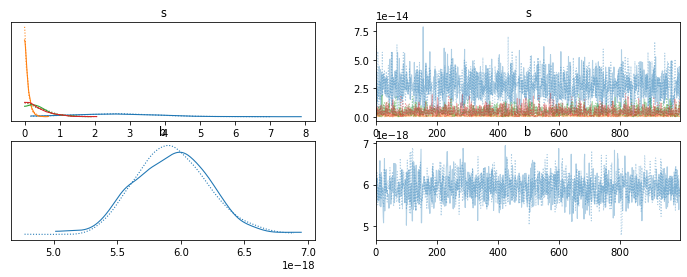

In [21]:
# Plot traces
trarr = pm.traceplot(trace)
fig = plt.gcf()

In [22]:
theta = []
C = []
for file in glob.glob('acisf09555_000N021_b0103*'):
    print(file)
    hdul = fits.open(file)
    theta_comp = []
    for value in hdul[5].data['psf_matrix'].T:
        #print(value)
        theta_comp.append([value[0],value[1],value[2],value[3],value[4]])
    C_comp = hdul[2].data['counts']
    theta_comp = np.array(theta_comp)
    print(theta_comp)
    print(np.shape(theta_comp))
    theta.append(theta_comp)
    C.append(C_comp)

acisf09555_000N021_b0103_b_detect_prep3.fits
[[2.87831252e+15 1.29095415e+12 2.52391013e+12 1.56012049e+12
  5.30870975e+12]
 [1.88597619e+14 3.36478051e+15 2.45986607e+11 2.59757640e+11
  2.55856352e+13]
 [6.65994339e+14 8.00249567e+11 1.77909561e+15 2.12762680e+14
  2.11416093e+13]
 [5.16931883e+12 3.97814490e+11 1.63897962e+12 2.22980126e+15
  1.49454517e+13]
 [1.87053998e+19 8.08880403e+18 2.81669867e+18 7.32529612e+18
  1.66170469e+20]]
(5, 5)


In [23]:
# Now we implement the PyMC3 model
basic_model = pm.Model()
with basic_model as model:
    # Priors for unknown model parameters
    s = pm.Uniform('s', lower=0.0, upper=1E-12, shape=(4,))
    b = pm.Uniform('b', lower=0.0, upper=1E-15)
    
    # Expected value of outcome
    mu = []
    for i in range(len(theta)):
        mu.append(s[0]*theta[i][0] + s[1]*theta[i][1] + s[2]*theta[i][2] + 
                  s[3]*theta[i][3] + b*theta[i][4]) # This also has to match the number of sources
    
    # Cash statistic
    def cash(observed_counts):
        logpm = np.array(mu - observed_counts*np.log(mu))
        return -2.0*np.sum(logpm)
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.DensityDist('C_obs', cash, observed=C)

In [24]:
# Now we do MCMC sampling
with basic_model:
    trace = pm.sample(1000,tune=1000,target_accept=0.9, cores=2, return_inferencedata=True)
    #trace = pm.sample(200,tune=1000,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.7151314670171274, but should be close to 0.9. Try to increase the number of tuning steps.


/var/folders/14/ndt0htr925q12gxv25s271x00000gn/T/ipykernel_84872/2006739585.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  trarr = pm.traceplot(trace)


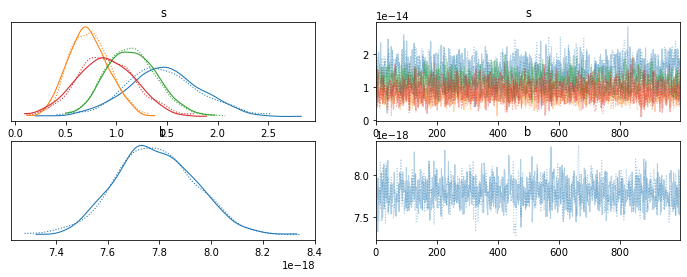

In [25]:
# Plot traces
trarr = pm.traceplot(trace)
fig = plt.gcf()